In [18]:
# ============================================
# ANALISIS MACHINE LEARNING - ONLINE RETAIL II
# UAS Machine Learning | End-to-end pipeline
# ============================================

# ========= 0) IMPORTS & CONFIG =========
import os
import json
import warnings
from datetime import timedelta

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

warnings.filterwarnings("ignore")
plt.style.use("default")
sns.set_palette("husl")

print("=== ANALISIS DATASET ONLINE RETAIL II ===")
print("UAS Machine Learning - Customer Segmentation & Sales Prediction\n")

=== ANALISIS DATASET ONLINE RETAIL II ===
UAS Machine Learning - Customer Segmentation & Sales Prediction



In [19]:
# ========= 1) DATA LOADING =========
print("1) LOADING DATASET...")
# Prioritas: file lokal yang kamu upload
CANDIDATE_PATHS = [
    "/mnt/data/online_retail_II.xlsx",     # path dari upload ChatGPT
    "online_retail_II.xlsx",               # path lokal relatif
    "Online Retail II.xlsx",               # varian nama
]

df = None
for p in CANDIDATE_PATHS:
    if os.path.exists(p):
        try:
            df = pd.read_excel(p)
            print(f"✓ Dataset dimuat dari file: {p}")
            break
        except Exception as e:
            print(f"!! Gagal baca {p}: {e}")

# Fallback 2: coba ucimlrepo (opsional)
if df is None:
    try:
        from ucimlrepo import fetch_ucirepo
        online_retail_ii = fetch_ucirepo(id=502)
        df = online_retail_ii.data.features
        print("✓ Dataset dimuat dari UCI ML Repository (ucimlrepo)")
    except Exception as e:
        print("⚠ Tidak menemukan file & ucimlrepo gagal. Membuat data simulasi untuk demo.")
        rng = np.random.default_rng(42)
        n = 50000
        df = pd.DataFrame({
            "InvoiceNo": [f"INV{i:06d}" for i in range(1, n+1)],
            "StockCode": rng.choice(list("ABCDE"), n),
            "Description": rng.choice([f"Product {x}" for x in list("ABCDE")], n),
            "Quantity": rng.poisson(5, n).clip(min=1),
            "InvoiceDate": pd.date_range("2010-01-01", "2011-12-09", periods=n),
            "UnitPrice": rng.gamma(2.0, 2.5, n).round(2),
            "CustomerID": rng.integers(10000, 20000, n),
            "Country": rng.choice(["United Kingdom", "France", "Germany", "EIRE"], n)
        })

print(f"Dataset shape: {df.shape}")
print(f"Memory usage: {df.memory_usage(deep=True).sum()/1024**2:.2f} MB\n")


1) LOADING DATASET...
✓ Dataset dimuat dari file: online_retail_II.xlsx
Dataset shape: (525461, 8)
Memory usage: 131.56 MB



In [20]:
# 2. BASIC DATA EXPLORATION
# ================================

print("2. BASIC DATA EXPLORATION")
print("-" * 40)

print("Dataset Info:")
print(df.info())
print("\nFirst 5 rows:")
print(df.head())
print("\nDataset description:")
print(df.describe())

# Check missing values
print("\nMissing values:")
missing_data = df.isnull().sum()
missing_percent = (missing_data / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing_data,
    'Percentage': missing_percent
})
print(missing_df)

2. BASIC DATA EXPLORATION
----------------------------------------
Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB
None

First 5 rows:
  Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12 

In [23]:
# ================================
# 3) PREPROCESSING (split tx vs customer)
# ================================
print("\n3) DATA PREPROCESSING & CLEANING")
print("-"*40)

# Deteksi nama kolom penting
col_invoice = next((c for c in ["InvoiceNo", "Invoice", "Invoice_ID"] if c in df.columns), None)
col_price   = next((c for c in ["UnitPrice", "Price"] if c in df.columns), None)
col_qty     = next((c for c in ["Quantity", "Qty"] if c in df.columns), None)
col_date    = next((c for c in ["InvoiceDate", "Date"] if c in df.columns), None)
if not all([col_invoice, col_price, col_qty, col_date]):
    raise KeyError(f"Kolom wajib tidak ditemukan. Cek df.columns -> "
                   f"invoice={col_invoice}, price={col_price}, qty={col_qty}, date={col_date}")

# Pastikan kolom opsional ada
df = df.copy(deep=True)
if "CustomerID" not in df.columns: df["CustomerID"] = np.nan
if "Description" not in df.columns: df["Description"] = np.nan
if "StockCode"  not in df.columns: df["StockCode"]  = "UNKNOWN"

print(f"Total records awal: {len(df):,}")

# --- df_tx: untuk EDA & model prediksi (TIDAK drop CustomerID) ---
df_tx = df.copy(deep=True)

# Isi deskripsi kosong
df_tx["Description"] = df_tx["Description"].fillna("Unknown Product")

# Tipe numerik
df_tx[col_qty]   = pd.to_numeric(df_tx[col_qty], errors="coerce")
df_tx[col_price] = pd.to_numeric(df_tx[col_price], errors="coerce")
before = len(df_tx)
df_tx = df_tx.dropna(subset=[col_qty, col_price]).copy()
print(f"Buang NaN {col_qty}/{col_price}: {before-len(df_tx):,} drop")

# Buang cancel (Invoice diawali 'C')
before = len(df_tx)
df_tx = df_tx[~df_tx[col_invoice].astype(str).str.startswith("C")].copy()
print(f"Remove cancellations: {before-len(df_tx):,} drop")

# Buang qty/price <= 0
before = len(df_tx)
df_tx = df_tx[(df_tx[col_qty] > 0) & (df_tx[col_price] > 0)].copy()
print(f"Remove negative/zero: {before-len(df_tx):,} drop")

# Tanggal & fitur waktu
df_tx[col_date] = pd.to_datetime(df_tx[col_date], errors="coerce")
before = len(df_tx)
df_tx = df_tx.dropna(subset=[col_date]).copy()
print(f"Invalid dates dropped: {before-len(df_tx):,}")

df_tx["TotalAmount"] = df_tx[col_qty] * df_tx[col_price]
df_tx["Year"]        = df_tx[col_date].dt.year
df_tx["Month"]       = df_tx[col_date].dt.month
df_tx["DayOfWeek"]   = df_tx[col_date].dt.dayofweek  # 0=Mon..6=Sun
df_tx["Hour"]        = df_tx[col_date].dt.hour

print(f"df_tx (untuk EDA/prediksi) shape: {df_tx.shape}")

# --- df_clean: untuk RFM/Clustering (HARUS punya CustomerID) ---
before = len(df_tx)
df_clean = df_tx.dropna(subset=["CustomerID"]).copy()
print(f"Drop missing CustomerID (khusus RFM): {before-len(df_clean):,} drop")
try:
    df_clean["CustomerID"] = pd.to_numeric(df_clean["CustomerID"], errors="coerce").astype("Int64")
except Exception:
    pass
print(f"df_clean (untuk RFM) shape: {df_clean.shape}")

# Safety: hentikan jika df_tx kosong
if len(df_tx) == 0:
    raise ValueError("Setelah cleaning, df_tx kosong. Cek filter: nama kolom invoice/price/qty/date, "
                     "pengecekan cancellation 'C', dan nilai <=0.")

print("✓ Preprocessing selesai\n")


3) DATA PREPROCESSING & CLEANING
----------------------------------------
Total records awal: 525,461
Buang NaN Quantity/Price: 0 drop
Remove cancellations: 10,206 drop
Remove negative/zero: 3,690 drop
Invalid dates dropped: 0
df_tx (untuk EDA/prediksi) shape: (511565, 14)
Drop missing CustomerID (khusus RFM): 511,565 drop
df_clean (untuk RFM) shape: (0, 14)
✓ Preprocessing selesai



4) EXPLORATORY DATA ANALYSIS
----------------------------------------


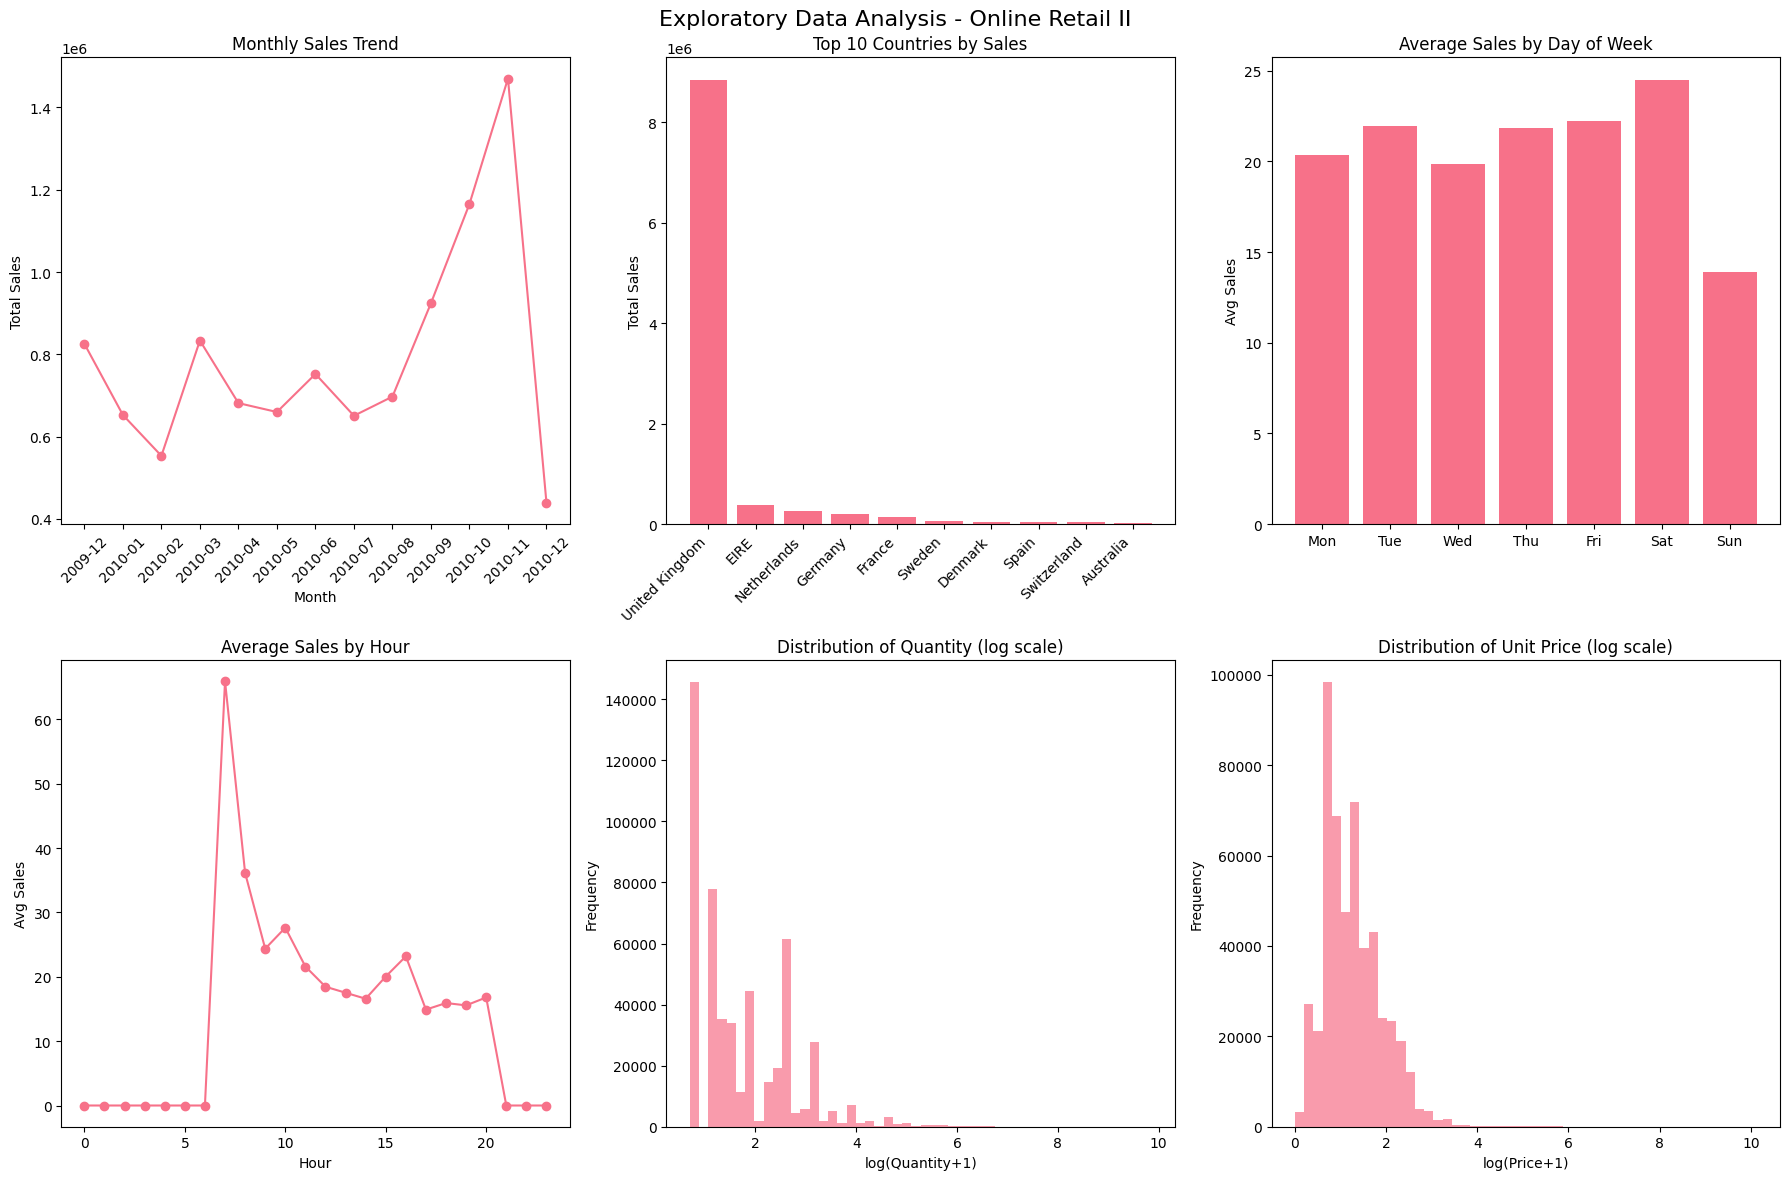

Dataset Statistics (transaksi):
- Total Revenue: 10,305,892.02
- Average Order Value (per invoice): 491.90
- Total Customers (non-null): 0
- Total Products: 4,251
- Total Transactions (unique invoice): 20,951
- Date Range: 2009-12-01 07:45:00 ~ 2010-12-09 20:01:00


In [24]:
# ================================
# 4) EXPLORATORY DATA ANALYSIS (pakai df_tx)
# ================================
print("4) EXPLORATORY DATA ANALYSIS")
print("-"*40)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle("Exploratory Data Analysis - Online Retail II", fontsize=16)

# 4.1 Monthly trend
monthly_sales = df_tx.groupby(df_tx[col_date].dt.to_period("M"))["TotalAmount"].sum()
axes[0,0].plot(monthly_sales.index.astype(str), monthly_sales.values, marker="o")
axes[0,0].set_title("Monthly Sales Trend")
axes[0,0].set_xlabel("Month"); axes[0,0].set_ylabel("Total Sales")
axes[0,0].tick_params(axis="x", rotation=45)

# 4.2 Top 10 Countries
country_sales = (df_tx.groupby("Country")["TotalAmount"]
                 .sum().sort_values(ascending=False).head(10))
axes[0,1].bar(range(len(country_sales)), country_sales.values)
axes[0,1].set_title("Top 10 Countries by Sales"); axes[0,1].set_ylabel("Total Sales")
axes[0,1].set_xticks(range(len(country_sales)))
axes[0,1].set_xticklabels(country_sales.index, rotation=45, ha="right")

# 4.3 Avg sales by day (pastikan 7 bar)
dow_names = ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"]
dow_sales = (df_tx.groupby("DayOfWeek")["TotalAmount"].mean()
             .reindex(range(7), fill_value=0))
axes[0,2].bar(dow_names, dow_sales.values)
axes[0,2].set_title("Average Sales by Day of Week"); axes[0,2].set_ylabel("Avg Sales")

# 4.4 Avg sales by hour (0-23; isi 0 jika kosong)
hourly_sales = (df_tx.groupby("Hour")["TotalAmount"].mean()
                .reindex(range(24), fill_value=0))
axes[1,0].plot(hourly_sales.index, hourly_sales.values, marker="o")
axes[1,0].set_title("Average Sales by Hour"); axes[1,0].set_xlabel("Hour"); axes[1,0].set_ylabel("Avg Sales")

# 4.5 Distribusi Quantity (log1p)
axes[1,1].hist(np.log1p(df_tx[col_qty]), bins=50, alpha=0.7)
axes[1,1].set_title("Distribution of Quantity (log scale)")
axes[1,1].set_xlabel("log(Quantity+1)"); axes[1,1].set_ylabel("Frequency")

# 4.6 Distribusi Unit Price (log1p)
axes[1,2].hist(np.log1p(df_tx[col_price]), bins=50, alpha=0.7)
axes[1,2].set_title("Distribution of Unit Price (log scale)")
axes[1,2].set_xlabel("log(Price+1)"); axes[1,2].set_ylabel("Frequency")

plt.tight_layout(); plt.show()

# Ringkasan metrik dasar (pakai df_tx)
aov = (df_tx.groupby(df_tx[col_invoice].astype(str))["TotalAmount"].sum()).mean()
print("Dataset Statistics (transaksi):")
print(f"- Total Revenue: {df_tx['TotalAmount'].sum():,.2f}")
print(f"- Average Order Value (per invoice): {aov:,.2f}")
print(f"- Total Customers (non-null): {df_tx['CustomerID'].nunique():,}")
print(f"- Total Products: {df_tx['StockCode'].nunique():,}")
print(f"- Total Transactions (unique invoice): {df_tx[col_invoice].astype(str).nunique():,}")
print(f"- Date Range: {df_tx[col_date].min()} ~ {df_tx[col_date].max()}")


5) CUSTOMER SEGMENTATION (K-MEANS CLUSTERING)
--------------------------------------------------
Mode RFM (fallback): per Invoice (proxy-customer) karena CustomerID minim/kosong
RFM Summary:
              Invoice       Recency     Frequency      Monetary
count   20951.000000  20951.000000  20951.000000  20951.000000
mean   514296.684406    165.825020     24.417212    491.904540
std     14002.149300    112.832346     39.105007   1116.156843
min    489434.000000      1.000000      1.000000      0.190000
25%    502491.500000     61.000000      6.000000    147.930000
50%    514664.000000    158.000000     15.000000    300.840000
75%    526186.500000    260.000000     28.000000    491.745000
max    538171.000000    374.000000    675.000000  49844.990000
RFM records after outlier removal: 18043 (from 20951)


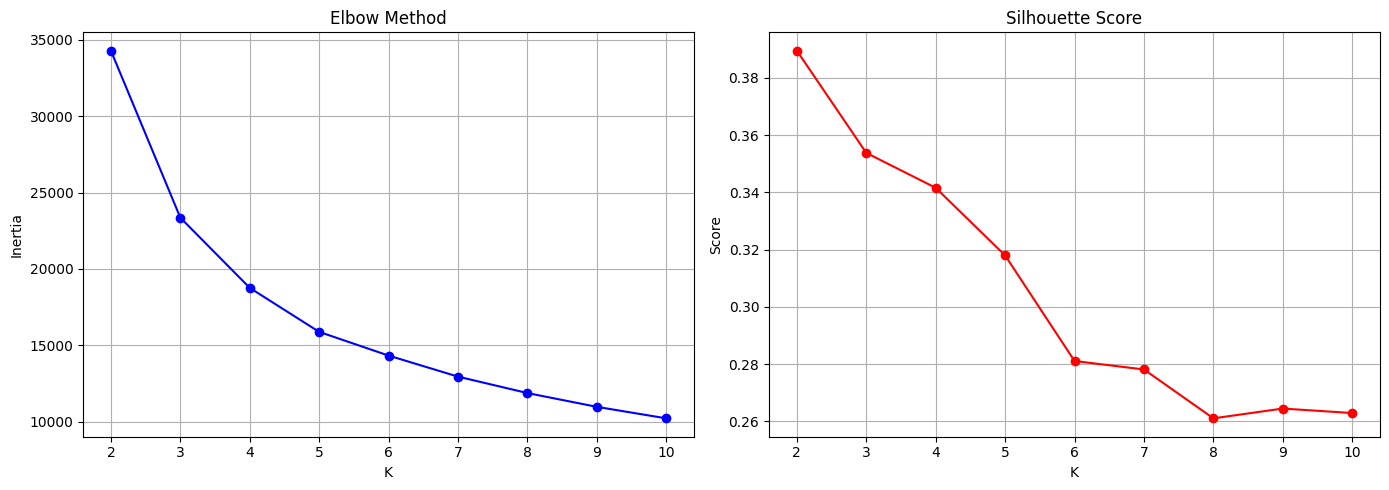

Optimal number of clusters: 2

Cluster Summary:
          Recency_mean  Recency_median  Frequency_mean  Frequency_med  \
Cluster                                                                
0              165.87           158.0           20.93           18.0   
1              167.17           161.0            2.83            2.0   

         Monetary_mean  Monetary_med  Count  
Cluster                                      
0               347.10        310.60  13417  
1                95.43         63.66   4626  


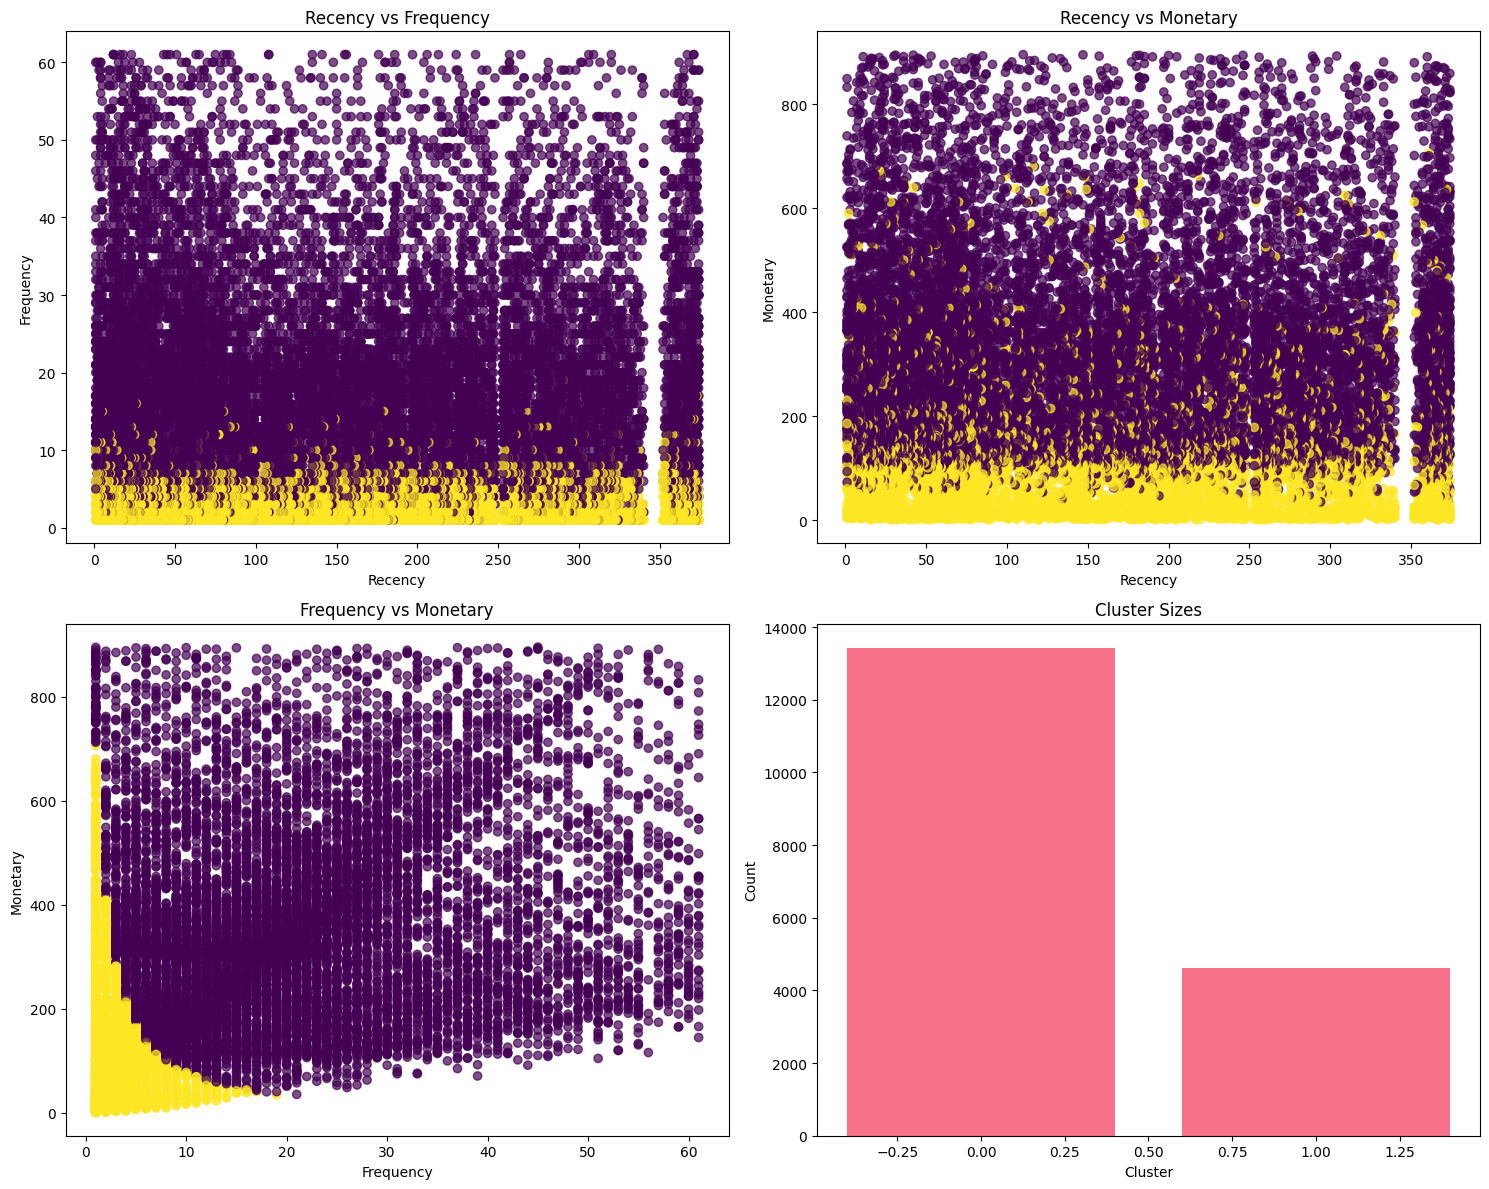

Silhouette Score: 0.389 | Inertia: 34288.31


In [26]:
# ================================
# 5) CUSTOMER SEGMENTATION (RFM + K-Means) — ROBUST
# ================================
print("\n5) CUSTOMER SEGMENTATION (K-MEANS CLUSTERING)")
print("-"*50)

import numpy as np
import pandas as pd
from datetime import timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# ---- Pastikan kolom kunci tersedia (deteksi fleksibel) ----
col_invoice = next((c for c in ["InvoiceNo", "Invoice", "Invoice_ID"] if c in df_tx.columns), None)
col_date    = next((c for c in ["InvoiceDate", "Date"] if c in df_tx.columns), None)

if col_invoice is None or col_date is None or "TotalAmount" not in df_tx.columns:
    raise KeyError("Kolom kunci untuk RFM tidak lengkap. Pastikan Invoice/Date/TotalAmount ada di df_tx.")

# ---- Tentukan mode RFM: CustomerID (utama) vs Invoice (fallback) ----
use_customer = ("CustomerID" in df_tx.columns) and (df_tx["CustomerID"].notna().sum() >= 2) and (df_tx["CustomerID"].nunique() >= 2)

if use_customer:
    id_col = "CustomerID"
    print("Mode RFM: per CustomerID")
    df_rfm_base = df_tx.dropna(subset=[id_col]).copy()
else:
    # Fallback: segmentasi per invoice (proxy-customer)
    id_col = col_invoice
    print("Mode RFM (fallback): per Invoice (proxy-customer) karena CustomerID minim/kosong")
    df_rfm_base = df_tx.copy()

# ---- Hitung tanggal referensi & agregasi RFM ----
reference_date = df_rfm_base[col_date].max() + timedelta(days=1)

# Recency: selisih hari dari transaksi terakhir per id
# Frequency: jumlah invoice unik per id (kalau id=invoice, gunakan jumlah baris dalam invoice)
# Monetary: total belanja
if id_col == "CustomerID":
    rfm = df_rfm_base.groupby(id_col).agg(
        Recency   = (col_date,   lambda x: (reference_date - x.max()).days),
        Frequency = (col_invoice, lambda x: pd.Series(x).astype(str).nunique()),
        Monetary  = ("TotalAmount", "sum")
    ).reset_index()
else:
    # id_col = invoice
    rfm = df_rfm_base.groupby(id_col).agg(
        Recency   = (col_date,   lambda x: (reference_date - x.max()).days),
        Frequency = (col_invoice, "size"),  # banyak baris item dalam invoice tsb
        Monetary  = ("TotalAmount", "sum")
    ).reset_index()

# Safety: butuh minimal 2 sampel
if len(rfm) < 2:
    raise ValueError("Sampel RFM < 2. Tidak dapat melakukan clustering. Cek kembali filter/ data input.")

print("RFM Summary:\n", rfm.describe())

# ---- Hapus outlier dengan IQR (opsional tapi disarankan) ----
def iqr_filter(d, col):
    Q1, Q3 = d[col].quantile(0.25), d[col].quantile(0.75)
    IQR = Q3 - Q1
    lo, hi = Q1 - 1.5*IQR, Q3 + 1.5*IQR
    return d[(d[col] >= lo) & (d[col] <= hi)]

rfm_clean = rfm.copy()
for c in ["Recency", "Frequency", "Monetary"]:
    if len(rfm_clean) > 0:
        rfm_clean = iqr_filter(rfm_clean, c)

print(f"RFM records after outlier removal: {len(rfm_clean)} (from {len(rfm)})")
if len(rfm_clean) < 2:
    raise ValueError("Setelah buang outlier, sampel < 2. Longgarkan filter atau lewati outlier removal.")

# ---- Transform & scale (log untuk distribusi miring) ----
X_rfm = rfm_clean[["Recency", "Frequency", "Monetary"]].copy()
X_rfm["Frequency"] = np.log1p(X_rfm["Frequency"])
X_rfm["Monetary"]  = np.log1p(X_rfm["Monetary"])

scaler_rfm = StandardScaler()
X_rfm_scaled = scaler_rfm.fit_transform(X_rfm)

# ---- Tentukan jumlah cluster optimal (Elbow + Silhouette) ----
K_range = [k for k in range(2, 11) if k < len(rfm_clean)]
if not K_range:
    # kalau data sedikit, pakai K=2
    K_range = [2]

inertias, sils = [], []
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_rfm_scaled)
    inertias.append(km.inertia_)
    # silhouette perlu >1 label unik
    if len(set(labels)) > 1:
        sils.append(silhouette_score(X_rfm_scaled, labels))
    else:
        sils.append(-1)

# Plot metrik
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
ax1.plot(K_range, inertias, "bo-")
ax1.set_title("Elbow Method"); ax1.set_xlabel("K"); ax1.set_ylabel("Inertia"); ax1.grid(True)
ax2.plot(K_range, sils, "ro-")
ax2.set_title("Silhouette Score"); ax2.set_xlabel("K"); ax2.set_ylabel("Score"); ax2.grid(True)
plt.tight_layout(); plt.show()

optimal_k = K_range[int(np.argmax(sils))]
print(f"Optimal number of clusters: {optimal_k}")

# ---- K-Means final ----
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
rfm_clean["Cluster"] = kmeans_final.fit_predict(X_rfm_scaled)

# ---- Ringkasan per cluster ----
cluster_summary = rfm_clean.groupby("Cluster").agg(
    Recency_mean   = ("Recency", "mean"),
    Recency_median = ("Recency", "median"),
    Frequency_mean = ("Frequency", "mean"),
    Frequency_med  = ("Frequency", "median"),
    Monetary_mean  = ("Monetary", "mean"),
    Monetary_med   = ("Monetary", "median"),
    Count          = (id_col, "count")
).round(2)
print("\nCluster Summary:\n", cluster_summary)

# ---- Visualisasi sederhana ----
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes[0,0].scatter(rfm_clean["Recency"], rfm_clean["Frequency"], c=rfm_clean["Cluster"], cmap="viridis", alpha=0.7)
axes[0,0].set_title("Recency vs Frequency"); axes[0,0].set_xlabel("Recency"); axes[0,0].set_ylabel("Frequency")

axes[0,1].scatter(rfm_clean["Recency"], rfm_clean["Monetary"], c=rfm_clean["Cluster"], cmap="viridis", alpha=0.7)
axes[0,1].set_title("Recency vs Monetary"); axes[0,1].set_xlabel("Recency"); axes[0,1].set_ylabel("Monetary")

axes[1,0].scatter(rfm_clean["Frequency"], rfm_clean["Monetary"], c=rfm_clean["Cluster"], cmap="viridis", alpha=0.7)
axes[1,0].set_title("Frequency vs Monetary"); axes[1,0].set_xlabel("Frequency"); axes[1,0].set_ylabel("Monetary")

cluster_counts = rfm_clean["Cluster"].value_counts().sort_index()
axes[1,1].bar(cluster_counts.index, cluster_counts.values)
axes[1,1].set_title("Cluster Sizes"); axes[1,1].set_xlabel("Cluster"); axes[1,1].set_ylabel("Count")

plt.tight_layout(); plt.show()

# ---- Skor siluet final ----
sil_score_val = silhouette_score(X_rfm_scaled, rfm_clean["Cluster"]) if rfm_clean["Cluster"].nunique()>1 else -1
print(f"Silhouette Score: {sil_score_val:.3f} | Inertia: {kmeans_final.inertia_:.2f}")

# Simpan artefak penting untuk step selanjutnya
optimal_k_final = optimal_k
rfm_result      = rfm_clean.copy()
silhouette_final= sil_score_val



6) SALES PREDICTION (RANDOM FOREST REGRESSION)
--------------------------------------------------
Features shape: (511565, 8), Target shape: (511565,)
Train set: (409252, 8), Test set: (102313, 8)
✓ Model training completed

Model Evaluation:
- Training RMSE: 9.26
- Test RMSE: 59.67
- Training R²: 0.9871
- Test R²: 0.7586
- Test MAE: 0.56

Feature Importance:
          Feature  Importance
1          Price    0.683635
0       Quantity    0.308769
3  StockCode_enc    0.003884
5          Month    0.001695
6      DayOfWeek    0.001199
7           Hour    0.000755
2    Country_enc    0.000053
4           Year    0.000010


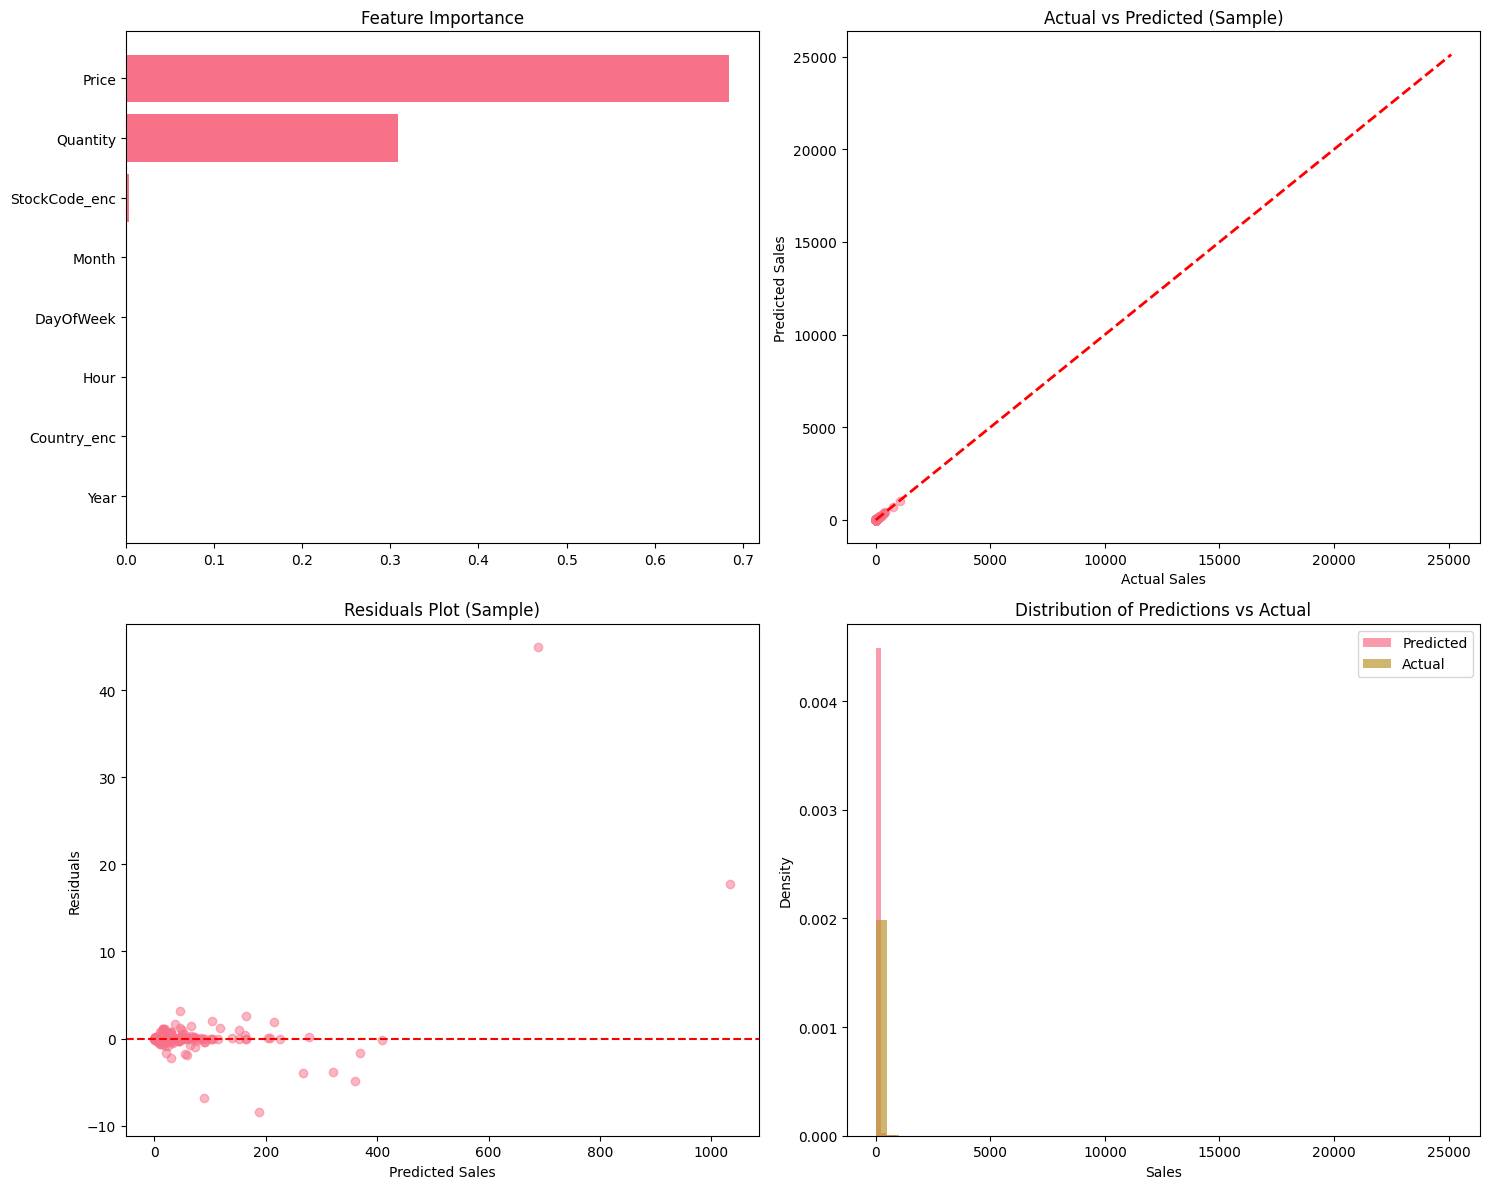

In [27]:
# ================================
# 6) SALES PREDICTION (RANDOM FOREST REGRESSION)
# ================================
print("\n6) SALES PREDICTION (RANDOM FOREST REGRESSION)")
print("-"*50)

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

# Pastikan kolom penting ada
if "TotalAmount" not in df_tx.columns:
    raise KeyError("Kolom 'TotalAmount' tidak ditemukan di df_tx.")

# Encode variabel kategorikal
le_country = LabelEncoder()
le_stockcode = LabelEncoder()

df_model = df_tx.copy()
df_model["Country_enc"]   = le_country.fit_transform(df_model["Country"].astype(str))
df_model["StockCode_enc"] = le_stockcode.fit_transform(df_model["StockCode"].astype(str))

# Deteksi nama kolom UnitPrice yang benar
col_price = next((c for c in ["UnitPrice", "Price"] if c in df_model.columns), None)
if col_price is None:
    raise KeyError("Kolom harga (UnitPrice/Price) tidak ditemukan.")

# Tentukan fitur & target
feature_columns = [
    "Quantity", col_price, "Country_enc", "StockCode_enc",
    "Year", "Month", "DayOfWeek", "Hour"
]
X = df_model[feature_columns].copy()
y = df_model["TotalAmount"].copy()

print(f"Features shape: {X.shape}, Target shape: {y.shape}")

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Train set: {X_train.shape}, Test set: {X_test.shape}")

# Train model Random Forest
rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)
print("✓ Model training completed")

# Prediksi
y_train_pred = rf_model.predict(X_train)
y_test_pred  = rf_model.predict(X_test)

# Evaluasi
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse  = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_r2   = r2_score(y_train, y_train_pred)
test_r2    = r2_score(y_test, y_test_pred)
test_mae   = mean_absolute_error(y_test, y_test_pred)

print("\nModel Evaluation:")
print(f"- Training RMSE: {train_rmse:,.2f}")
print(f"- Test RMSE: {test_rmse:,.2f}")
print(f"- Training R²: {train_r2:.4f}")
print(f"- Test R²: {test_r2:.4f}")
print(f"- Test MAE: {test_mae:,.2f}")

# Feature importance
feature_importance = (
    pd.DataFrame({
        "Feature": feature_columns,
        "Importance": rf_model.feature_importances_
    })
    .sort_values("Importance", ascending=False)
)
print("\nFeature Importance:\n", feature_importance)

# Visualisasi hasil
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot importance
axes[0,0].barh(feature_importance["Feature"], feature_importance["Importance"])
axes[0,0].invert_yaxis()
axes[0,0].set_title("Feature Importance")

# Actual vs Predicted (sample)
sample_size = min(1000, len(y_test))
sample_idx  = np.random.choice(len(y_test), sample_size, replace=False)
axes[0,1].scatter(y_test.iloc[sample_idx], y_test_pred[sample_idx], alpha=0.5)
mn, mx = float(min(y_test.min(), y_test_pred.min())), float(max(y_test.max(), y_test_pred.max()))
axes[0,1].plot([mn, mx], [mn, mx], "r--", lw=2)
axes[0,1].set_title("Actual vs Predicted (Sample)")
axes[0,1].set_xlabel("Actual Sales")
axes[0,1].set_ylabel("Predicted Sales")

# Residuals plot
residuals = y_test - y_test_pred
axes[1,0].scatter(y_test_pred[sample_idx], residuals.iloc[sample_idx], alpha=0.5)
axes[1,0].axhline(y=0, color="r", linestyle="--")
axes[1,0].set_title("Residuals Plot (Sample)")
axes[1,0].set_xlabel("Predicted Sales")
axes[1,0].set_ylabel("Residuals")

# Distribusi prediksi vs aktual
axes[1,1].hist(y_test_pred, bins=50, alpha=0.7, label="Predicted", density=True)
axes[1,1].hist(y_test, bins=50, alpha=0.7, label="Actual", density=True)
axes[1,1].set_title("Distribution of Predictions vs Actual")
axes[1,1].set_xlabel("Sales")
axes[1,1].set_ylabel("Density")
axes[1,1].legend()

plt.tight_layout()
plt.show()


In [28]:
# ================================
# 7) BUSINESS INSIGHTS & INTERPRETATION
# ================================
print("\n7) BUSINESS INSIGHTS & INTERPRETATION")
print("-"*50)

# -------- Customer Segmentation Insights --------
print("\nCUSTOMER SEGMENTATION INSIGHTS:")
print("="*35)

# Ambil centroid cluster dalam skala asli
centers_std   = kmeans_final.cluster_centers_
centers_orig  = scaler_rfm.inverse_transform(centers_std)

# Kembalikan nilai Frequency & Monetary dari log1p
cluster_insights = []
for i, (rec, freq, mon) in enumerate(centers_orig):
    freq_unlog = np.expm1(freq)
    mon_unlog  = np.expm1(mon)
    count_cluster = (rfm_result["Cluster"] == i).sum()

    # Segmentasi sederhana berdasarkan nilai centroid
    if rec < 50 and freq_unlog > 3 and mon_unlog > 200:
        segment = "Champions"
        strategy = "Reward them, ask for reviews, upsell"
    elif rec < 100 and mon_unlog > 500:
        segment = "Loyal Customers"
        strategy = "Personalized offers, maintain relationship"
    elif rec > 150:
        segment = "At Risk"
        strategy = "Win-back campaigns"
    elif mon_unlog > 1000:
        segment = "Big Spenders"
        strategy = "Exclusive deals, VIP treatment"
    else:
        segment = "Regular Customers"
        strategy = "Engagement campaigns"

    cluster_insights.append({
        "Cluster": i,
        "Size": count_cluster,
        "Avg_Recency": rec,
        "Avg_Frequency": freq_unlog,
        "Avg_Monetary": mon_unlog,
        "Segment": segment,
        "Strategy": strategy
    })

# Tampilkan insight per cluster
for seg in cluster_insights:
    print(f"\nCluster {seg['Cluster']} - {seg['Segment']}")
    print(f"  Size: {seg['Size']} entities")
    print(f"  Avg Recency: {seg['Avg_Recency']:.1f} days")
    print(f"  Avg Frequency: {seg['Avg_Frequency']:.1f} transactions")
    print(f"  Avg Monetary: {seg['Avg_Monetary']:.2f}")
    print(f"  Recommended Strategy: {seg['Strategy']}")

# -------- Sales Prediction Insights --------
print("\nSALES PREDICTION INSIGHTS:")
print("="*30)
print(f"Model Performance: R² = {test_r2:.3f} (explains {test_r2*100:.1f}% of variance)")
print(f"Average prediction error (MAE): {test_mae:,.2f}")

top_features = feature_importance.head(3)
print("\nTop 3 Most Important Factors for Sales:")
for idx, row in top_features.iterrows():
    print(f"  {idx+1}. {row['Feature']}: {row['Importance']:.3f}")

# -------- Ringkasan Business Recommendation --------
print("\nBUSINESS RECOMMENDATIONS:")
print("="*30)
print("1. Fokus pada segmen 'Champions' dan 'Loyal Customers' dengan program loyalitas dan upselling.")
print("2. Lakukan kampanye khusus untuk segmen 'At Risk' dan 'Big Spenders' untuk mempertahankan revenue.")
print(f"3. Optimalkan faktor '{top_features.iloc[0]['Feature']}' karena ini paling berpengaruh terhadap sales.")
print("4. Gunakan model prediksi untuk mendukung perencanaan inventory dan forecasting penjualan.")



7) BUSINESS INSIGHTS & INTERPRETATION
--------------------------------------------------

CUSTOMER SEGMENTATION INSIGHTS:

Cluster 0 - At Risk
  Size: 13417 entities
  Avg Recency: 165.9 days
  Avg Frequency: 17.3 transactions
  Avg Monetary: 301.65
  Recommended Strategy: Win-back campaigns

Cluster 1 - At Risk
  Size: 4626 entities
  Avg Recency: 167.2 days
  Avg Frequency: 2.3 transactions
  Avg Monetary: 50.45
  Recommended Strategy: Win-back campaigns

SALES PREDICTION INSIGHTS:
Model Performance: R² = 0.759 (explains 75.9% of variance)
Average prediction error (MAE): 0.56

Top 3 Most Important Factors for Sales:
  2. Price: 0.684
  1. Quantity: 0.309
  4. StockCode_enc: 0.004

BUSINESS RECOMMENDATIONS:
1. Fokus pada segmen 'Champions' dan 'Loyal Customers' dengan program loyalitas dan upselling.
2. Lakukan kampanye khusus untuk segmen 'At Risk' dan 'Big Spenders' untuk mempertahankan revenue.
3. Optimalkan faktor 'Price' karena ini paling berpengaruh terhadap sales.
4. Gunakan m

In [29]:
# ================================
# 8) SAVE RESULTS
# ================================
print("\n8) SAVING RESULTS")
print("-"*20)

import os, json
from datetime import datetime

# Buat folder output
OUT_DIR = "outputs"
os.makedirs(OUT_DIR, exist_ok=True)

# 1) Simpan hasil segmentasi (RFM + Cluster)
# rfm_result dibuat di langkah 5 (berisi kolom: [id, Recency, Frequency, Monetary, Cluster])
if 'rfm_result' not in globals():
    raise RuntimeError("rfm_result tidak ditemukan. Jalankan proses 5 (clustering) terlebih dahulu.")

# Tentukan nama kolom ID (customer atau invoice)
id_col_saved = "CustomerID" if "CustomerID" in rfm_result.columns else rfm_result.columns[0]
rfm_save_path = os.path.join(OUT_DIR, "customer_segments.csv")
rfm_result.to_csv(rfm_save_path, index=False)
print(f"✓ Customer segments saved to '{rfm_save_path}' "
      f"(ID column: {id_col_saved}, rows: {len(rfm_result):,})")

# 2) Simpan Feature Importance dari model regresi (langkah 6)
if 'feature_importance' not in globals():
    raise RuntimeError("feature_importance tidak ditemukan. Jalankan proses 6 (sales prediction) terlebih dahulu.")
fi_save_path = os.path.join(OUT_DIR, "feature_importance.csv")
feature_importance.to_csv(fi_save_path, index=False)
print(f"✓ Feature importance saved to '{fi_save_path}'")

# 3) Simpan sampel prediksi (aktual vs prediksi)
if 'y_test' not in globals() or 'y_test_pred' not in globals():
    raise RuntimeError("y_test / y_test_pred tidak ditemukan. Jalankan proses 6 terlebih dahulu.")
pred_df = pd.DataFrame({
    "Actual": y_test.values,
    "Predicted": y_test_pred,
    "Error": y_test.values - y_test_pred
})
pred_save_path = os.path.join(OUT_DIR, "predictions_sample.csv")
pred_df.head(1000).to_csv(pred_save_path, index=False)
print(f"✓ Prediction results (sample) saved to '{pred_save_path}'")

# 4) Simpan ringkasan analisis ke JSON
# Ambil metrik dari langkah 5 & 6 (pakai nilai fallback jika tidak ada)
optimal_clusters = int(globals().get("optimal_k_final", globals().get("optimal_k", 0)))
silhouette_val   = float(globals().get("silhouette_final", globals().get("sil_score", -1)))

# Metrik regresi
test_r2   = float(globals().get("test_r2", 0.0))
test_rmse = float(globals().get("test_rmse", 0.0))
test_mae  = float(globals().get("test_mae", 0.0))

# Ringkasan dataset (pakai df_tx untuk statistik transaksi)
if 'df_tx' not in globals():
    raise RuntimeError("df_tx tidak ditemukan. Pastikan proses 4 (EDA) sudah dijalankan.")
total_revenue   = float(df_tx["TotalAmount"].sum())
total_customers = int(df_tx["CustomerID"].nunique()) if "CustomerID" in df_tx.columns else 0
total_products  = int(df_tx["StockCode"].nunique()) if "StockCode" in df_tx.columns else 0
total_invoices  = int(df_tx[col_invoice].astype(str).nunique())
date_min        = pd.to_datetime(df_tx[col_date]).min()
date_max        = pd.to_datetime(df_tx[col_date]).max()

summary = {
    "Generated_At": datetime.now().isoformat(timespec="seconds"),
    "Dataset_Records": int(len(df_tx)),
    "Date_Range": {"min": str(date_min), "max": str(date_max)},
    "Total_Revenue": total_revenue,
    "Total_Customers": total_customers,
    "Total_Products": total_products,
    "Total_Invoices": total_invoices,
    "Clustering_Silhouette_Score": silhouette_val,
    "Optimal_Clusters": optimal_clusters,
    "Regression_R2_Score": test_r2,
    "Regression_RMSE": test_rmse,
    "Regression_MAE": test_mae,
    "Segmentation_ID_Level": "CustomerID" if id_col_saved == "CustomerID" else "Invoice (proxy)"
}

summary_path = os.path.join(OUT_DIR, "analysis_summary.json")
with open(summary_path, "w") as f:
    json.dump(summary, f, indent=2)
print(f"✓ Analysis summary saved to '{summary_path}'")

print("\nFiles generated in 'outputs/':")
for fname in ["customer_segments.csv", "feature_importance.csv", "predictions_sample.csv", "analysis_summary.json"]:
    print(f"- {fname}")



8) SAVING RESULTS
--------------------
✓ Customer segments saved to 'outputs/customer_segments.csv' (ID column: Invoice, rows: 18,043)
✓ Feature importance saved to 'outputs/feature_importance.csv'
✓ Prediction results (sample) saved to 'outputs/predictions_sample.csv'
✓ Analysis summary saved to 'outputs/analysis_summary.json'

Files generated in 'outputs/':
- customer_segments.csv
- feature_importance.csv
- predictions_sample.csv
- analysis_summary.json
